# 02_define_extremes.ipynb
### Standardize anomalies and define extremes

This notebook loads the data from [01_ENSO_models.ipynb](01_ENSO_models.ipynb) and detects extremes values. Detrended anomalies are standardized by the monthly mean standard deviation and extreme values are identified using the 90th percentile at each spatial point.


![preprocess_flow](images/02_define_extremes.png)


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Import data
- preprocessed monthly averaged and detrended OISST v2.1 data with Nino indices regressed out.


In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/ENSO_models_OISSTv21.nc',
                  '/burg/abernathey/users/hillary/oisst_v21/preprocessed_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ds

<xarray.Dataset>
Dimensions:                 (time: 478, lat: 720, lon: 1440)
Coordinates:
  * time                    (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                     (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                     (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables: (12/15)
    Nino3                   (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    Nino3_4                 (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    Nino4                   (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    ssta_Nino3              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_Nino3_4            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_Nino4              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ...                      ...
    lsmask                  (lat, lon) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_trend              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mean                    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    trend                   (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    seas                    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  preprocessed monthly averaged and detrended OISST v2.1 data

#### Standardize SST anomalies by dividing by the monthly standard deviatoin
This places equal variance on SSTa at all spatial points

In [3]:
# compute monthly standard deviation
stdev_notrend = ds.ssta_notrend.groupby(ds.time.dt.month).std()

# divide by standard deviation
ssta_stn_notrend = ds.ssta_notrend.groupby(ds.time.dt.month)/stdev_notrend


#### Calculate 90th percentile threshold from the origonal detrended SST anomalies

In [18]:
# Define extreme threshold as the 90th percentile
thresh = .9

# Rechunk time dim
if ssta_stn_notrend.chunks:
    ssta_stn_notrend = ssta_stn_notrend.chunk({'time': -1})
    
# Compute values of the monthly threshold
prct_notrend = ds.ssta_notrend.groupby(ds.time.dt.month).quantile(thresh, dim='time', keep_attrs=True, skipna=True)


#### Find where SSTA exceeds the 90th percentile threshold

In [26]:
# Take only the SSTa that exceeds the calculated monthly threshold

mhw_ssta_notrend = ds.ssta_notrend.groupby(ds.time.dt.month).where(ds.ssta_notrend.groupby(ds.time.dt.month)>prct_notrend)
mhw_ssta_notrend_noNino3 = ds.ssta_notrend_noNino3.groupby(ds.time.dt.month).where(ds.ssta_notrend_noNino3.groupby(ds.time.dt.month) > prct_notrend)
mhw_ssta_notrend_noNino3_4 = ds.ssta_notrend_noNino3_4.groupby(ds.time.dt.month).where(ds.ssta_notrend_noNino3_4.groupby(ds.time.dt.month) > prct_notrend)
mhw_ssta_notrend_noNino4 = ds.ssta_notrend_noNino4.groupby(ds.time.dt.month).where(ds.ssta_notrend_noNino4.groupby(ds.time.dt.month) > prct_notrend)


#### Quick sanity check

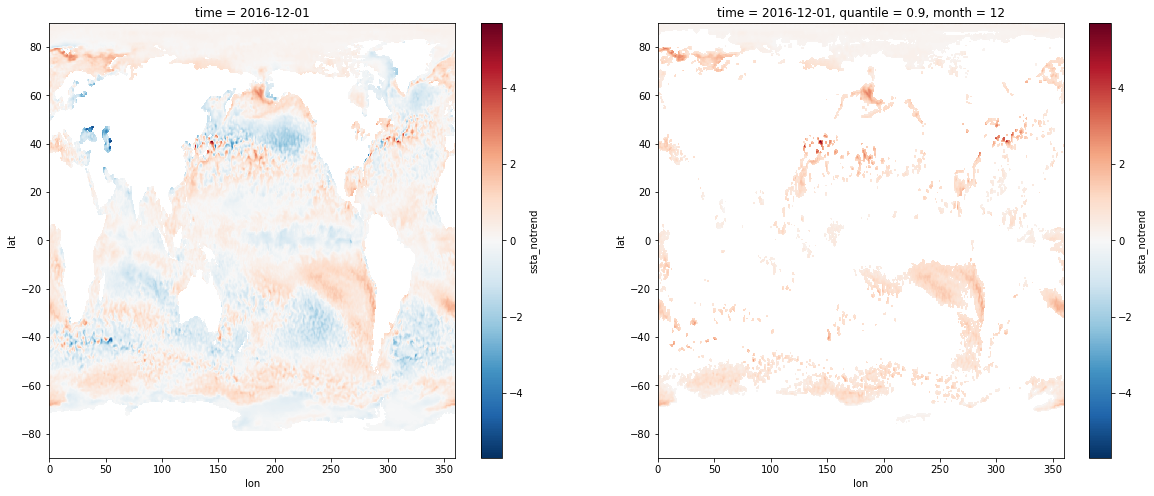

In [27]:
mhw_ssta_notrend_noNino3

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ds.ssta_notrend.sel(time=('2016-12-01')).plot(ax=ax1)
mhw_ssta_notrend.sel(time=('2016-12-01')).plot(ax=ax2);


### Save output 

In [41]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_new = xr.Dataset(
    data_vars=dict(
        ssta_stn_notrend=(['time', 'lat', 'lon'], ssta_stn_notrend.data),
        prct_notrend = (['month','lat', 'lon'], prct_notrend.data),
        
        mhw_ssta_notrend = (['time', 'lat', 'lon'], mhw_ssta_notrend.data),
        mhw_ssta_notrend_noNino3 = (['time', 'lat', 'lon'], mhw_ssta_notrend_noNino3.data),
        mhw_ssta_notrend_noNino3_4=(['time', 'lat', 'lon'], mhw_ssta_notrend_noNino3_4.data),
        mhw_ssta_notrend_noNino4=(['time', 'lat', 'lon'], mhw_ssta_notrend_noNino4.data),     
    ),
    coords=dict(
        month=(['month'], prct_notrend.month.data),
        time=(['time'], ds.time.data),
        lat=(['lat'], ds.lat.data),
        lon=(['lon'], ds.lon.data),
    ),
    attrs=dict(description="standardized SST anomalies above positive extreme threshold", 
               threshold=thresh, 
               data='preprocessed monthly averaged OISST v2.1'),
)

ds_new.to_netcdf(path+'positive_extremes_OISSTv21.nc', mode='w')